In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [2]:
# !git clone https://github.com/time-series-foundation-models/lag-llama/


In [1]:
cd ../lag-llama

/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama


In [2]:
# !pip3 install -r requirements.txt --quiet
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
# from gluonts.dataset.repository.datasets import get_dataset

# from gluonts.dataset.pandas import PandasDataset
# from gluonts.dataset.split import split
from gluonts.dataset.common import ListDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns

from sklearn.metrics import mean_absolute_error

/var/folders/x7/k4v9jmwn26x9tw0wd3vfqdw00000gn/T/ipykernel_81690/4258175932.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
# Read data
# ==============================================================================
# data_dir = '/content/drive/MyDrive/Python Scripts/Lag Llama experiments/Data'
data_dir = '../Data/spain/four years'

df = pd.read_csv(data_dir + '/spain_clean.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')
# df['item_id'] = 'waves'
df.drop(columns = ['period'], inplace = True)
df.head()

# Train-val-test split
# ==============================================================================
# one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_train = two_months + two_months
end_val = two_months

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()
# df_test = df.iloc[end_train:]

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-18 00:00:00 --- 2024-02-19 23:00:00  (n=32208)
Validation dates : 2024-02-20 00:00:00 --- 2024-04-19 23:00:00  (n=1440)
Test dates       : 2024-04-20 00:00:00 --- 2024-06-18 23:00:00  (n=1440)


In [5]:
def create_gluonts_dataset(df, freq, target_column):
    series = {
        "start": df.index[0],  # start date of the time series
        "target": df[target_column].values,  # target values
    }

    dataset = ListDataset([series], freq=freq)
    return dataset

# Create the GluonTS dataset
train = create_gluonts_dataset(df_train, freq='1H', target_column='wave_height')
test = create_gluonts_dataset(df_test, freq='1H', target_column='wave_height')
val = create_gluonts_dataset(df_val, freq='1H', target_column='wave_height')

print('Train dataset:', train)
print('Validation dataset:',val)
print('Test dataset:',test)

Train dataset: [{'start': Period('2020-06-18 00:00', 'H'), 'target': array([0.78, 0.76, 0.74, ..., 1.11, 1.13, 1.16], dtype=float32)}]
Validation dataset: [{'start': Period('2024-02-20 00:00', 'H'), 'target': array([1.2 , 1.23, 1.26, ..., 1.39, 1.33, 1.26], dtype=float32)}]
Test dataset: [{'start': Period('2024-04-20 00:00', 'H'), 'target': array([1.2 , 1.15, 1.11, ..., 0.86, 0.84, 0.82], dtype=float32)}]


We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [44]:
def get_lag_llama_predictions(dataset,
                                model_ckpt,
                                prediction_length = 24, 
                                context_length=32, 
                                num_samples=20, 
                                device="cpu", 
                                batch_size=32, 
                                nonnegative_pred_samples=True):
    
    
    _device = torch.device(device)
    _ckpt = torch.load(model_ckpt, map_location=_device)
    estimator_args = _ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        # ckpt_path="lag-llama.ckpt",
        ckpt_path = model_ckpt,
        prediction_length=prediction_length,
        context_length=context_length,
        device = _device,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module().to(device)
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset[0]['target']), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset[0]['target']), desc="Ground truth"))

    return forecasts, tss

In [45]:
def recursive_forecast(
    model_ckpt,
    context_df, 
    test_df,
    prediction_length = 24,
    context_length = 32,
    device = 'cpu', 
    num_samples = 100):

    context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

    _device = torch.device(device)

    batch_size = prediction_length  # Number of observations to add to context at each step of the forecast. Same as prediction length. 
    total_length = len(df_test)  # Total length of the target DataFrame


    all_point_forecasts = []

    # Append batches sequentially to the target DataFrame
    for i in range(0, total_length, batch_size):

        # Prediction based on context dataset
        forecasts, tss = get_lag_llama_predictions(
        model_ckpt = model_ckpt,
        dataset = context_gdf,
        prediction_length=prediction_length,
        num_samples=num_samples,
        context_length=context_length,
        device=_device
        )

        point_forecast = list(forecasts[0].mean)
        all_point_forecasts.extend(point_forecast)

        # Update context dataset
        batch_start_index = i
        batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of target_df
        batch = test_df.iloc[batch_start_index:batch_end_index]
        context_df = pd.concat([context_df, batch], ignore_index=False)
        context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

    test_n_preds_df = test_df.copy()
    test_n_preds_df['forecasts'] = all_point_forecasts

    return test_n_preds_df


## Zero-shot forecasting

In [46]:
# Forecast parameters
checkpoint = 'lag-llama/lag-llama.ckpt'
prediction_length = 24
context_length = 32
num_samples = 100
device = torch.device('cpu')

In [47]:
forecasts, tss = get_lag_llama_predictions(
    test,
    model_ckpt = checkpoint,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

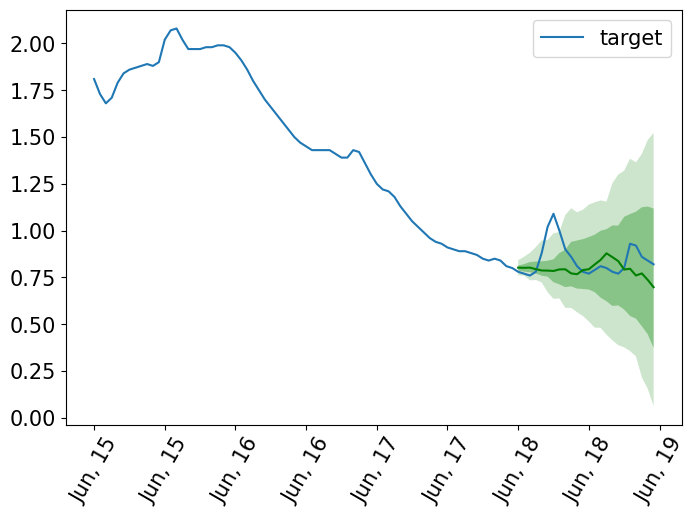

In [48]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [32]:
# # Recursive multi-step forecasting
# # ==============================================================================
# context_df = df_train[-48:]
# context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

# batch_size = 1  # Number of observations to add to context at each step of the forecast. Same as prediction length. 
# total_length = len(df_test)  # Total length of the target DataFrame

# prediction_length = 24
# context_length = 32
# num_samples = 100
# device = torch.device('cpu')

# all_point_forecasts = []

# # Append batches sequentially to the target DataFrame
# for i in range(0, total_length, batch_size):

#     # Prediction based on context dataset
#     forecasts, tss = get_lag_llama_predictions(
#     context_gdf,
#     prediction_length=prediction_length,
#     num_samples=num_samples,
#     context_length=context_length,
#     device=device
#     )

#     point_forecast = list(forecasts[0].mean)
#     all_point_forecasts.extend(point_forecast)

#     # Update context dataset
#     batch_start_index = i
#     batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of target_df
#     batch = df_test.iloc[batch_start_index:batch_end_index]
#     context_df = pd.concat([context_df, batch], ignore_index=False)
#     context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

# df_test['forecast'] = all_point_forecasts
# df_test.head()

In [16]:
df_forecasts = recursive_forecast(model_ckpt = checkpoint, context_df=df_train[-48:], test_df = df_test)
df_forecasts

Forecasting batches:   0%|          | 0/48 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/48 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/72 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/72 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/96 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/96 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/432 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/456 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/456 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/480 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/480 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/504 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/504 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/528 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/528 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/552 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/552 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/576 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/576 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/600 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/600 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/624 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/624 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/648 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/648 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/672 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/672 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/696 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/696 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/720 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/720 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/744 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/744 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/768 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/768 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/792 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/792 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/816 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/816 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/840 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/840 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/864 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/864 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/888 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/888 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/912 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/912 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/936 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/936 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/960 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/960 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/984 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/984 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1008 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1008 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1032 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1032 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1056 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1056 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1080 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1080 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1128 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1128 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1152 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1152 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1176 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1176 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1200 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1200 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1224 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1224 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1248 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1248 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1272 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1272 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1296 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1296 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1320 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1320 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1344 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1344 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1368 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1368 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1392 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1392 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1416 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1416 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1464 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1464 [00:00<?, ?it/s]

wave_height  forecasts
datetime                                   
2024-04-20 00:00:00         1.20   1.176658
2024-04-20 01:00:00         1.15   1.201162
2024-04-20 02:00:00         1.11   1.165680
2024-04-20 03:00:00         1.08   1.180294
2024-04-20 04:00:00         1.08   1.251795
...                          ...        ...
2024-06-18 19:00:00         0.93   1.507554
2024-06-18 20:00:00         0.92   1.508000
2024-06-18 21:00:00         0.86   1.514802
2024-06-18 22:00:00         0.84   1.520004
2024-06-18 23:00:00         0.82   1.515990

[1440 rows x 2 columns]

In [23]:
# # Plot predictions vs real value
# # ======================================================================================
# fig = go.Figure()
# trace1 = go.Scatter(x=df_forecasts.index, y=df_forecasts['wave_height'], name="actual", mode="lines")
# trace2 = go.Scatter(x=df_forecasts.index, y=df_forecasts['forecasts'], name="prediction", mode="lines")
# fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.update_layout(
#     title="Actual value vs predicted in test data",
#     xaxis_title="Date time",
#     yaxis_title="Wave height (meters)",
#     width=800,
#     height=400,
#     margin=dict(l=20, r=20, t=35, b=20),
#     legend=dict(
#         orientation="h",
#         yanchor="top",
#         y=1.1,
#         xanchor="left",
#         x=0.001
#     )
# )

# fig.show()

In [21]:
def plot_backtest_preds(df_actual_pred, actual_col, pred_col):
    fig = go.Figure()
    trace1 = go.Scatter(x=df_actual_pred.index, y=df_actual_pred[actual_col], name="actual", mode="lines")
    trace2 = go.Scatter(x=df_actual_pred.index, y=df_actual_pred[pred_col], name="prediction", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Actual value vs predicted in test data",
        xaxis_title="Date time",
        yaxis_title="Wave height (meters)",
        width=800,
        height=400,
        margin=dict(l=20, r=20, t=35, b=20),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.001
        )
    )

    fig.show()

In [22]:
plot_backtest_preds(df_forecasts, 'wave_height', 'forecasts')

In [29]:
metric = mean_absolute_error(df_test['wave_height'], df_test['forecast'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.3870048384426369


## Forecasting with fine-tuned models

In [31]:
ckpt_dir = 'lightning_logs'

cl16 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'
cl32 = ckpt_dir + '/cl32_lr10e3/checkpoints/epoch=41-step=2100.ckpt'
cl64 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'

checkpoints = [cl16, cl32, cl64]

### Model with cl = 16


In [32]:
# Produce forecasts
df_forecasts_16 = recursive_forecast(model_ckpt = cl16, context_df=df_train[-16:], test_df = df_test)

Forecasting batches:   0%|          | 0/16 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/16 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/40 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/40 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/64 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/64 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/88 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/88 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/544 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/568 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/568 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/592 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/592 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/616 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/616 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/640 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/640 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/664 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/664 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/688 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/688 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/712 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/712 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/736 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/736 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/760 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/760 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/784 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/784 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/808 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/808 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/832 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/832 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/856 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/856 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/880 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/880 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/904 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/904 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/928 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/928 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/952 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/952 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/976 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/976 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1000 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1024 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1048 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1048 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1072 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1072 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1096 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1432 [00:00<?, ?it/s]

In [33]:
# Plot
plot_backtest_preds(df_forecasts_16, 'wave_height', 'forecasts')

In [36]:
# Evaluation 
metric = mean_absolute_error(df_forecasts_16['wave_height'], df_forecasts_16['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.6956580517483462


### Model with cl = 32


In [37]:
# Produce forecasts
df_forecasts_32 = recursive_forecast(model_ckpt = cl32, context_df=df_train[-32:], test_df = df_test)

Forecasting batches:   0%|          | 0/32 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/32 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/56 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/56 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/80 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/80 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/128 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/128 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/152 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/152 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/176 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/176 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/200 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/200 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/224 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/224 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/248 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/248 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/272 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/272 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/296 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/296 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/320 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/320 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/344 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/344 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/368 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/368 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/392 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/392 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/416 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/416 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/440 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/464 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/464 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/488 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/488 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/536 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/536 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/560 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/560 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/584 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/584 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/608 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/608 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/632 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/632 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/656 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/656 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/680 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/680 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/704 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/704 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/728 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/728 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/752 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/752 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/776 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/776 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/800 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/800 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/824 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/824 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/848 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/848 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/872 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/872 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/896 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/896 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/920 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/920 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/944 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/944 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/968 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/968 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/992 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/992 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1016 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1016 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1040 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1040 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1064 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1064 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1088 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1088 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1448 [00:00<?, ?it/s]

In [38]:
# Plot
plot_backtest_preds(df_forecasts_32, 'wave_height', 'forecasts')

# Evaluation 
metric = mean_absolute_error(df_forecasts_32['wave_height'], df_forecasts_32['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.9060648714436426


### Model with cl = 64

In [39]:
# Produce forecasts
df_forecasts_64 = recursive_forecast(model_ckpt = cl64, context_df=df_train[-64:], test_df = df_test)

Forecasting batches:   0%|          | 0/64 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/64 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/88 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/88 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/544 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/568 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/568 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/592 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/592 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/616 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/616 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/640 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/640 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/664 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/664 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/688 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/688 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/712 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/712 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/736 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/736 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/760 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/760 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/784 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/784 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/808 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/808 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/832 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/832 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/856 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/856 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/880 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/880 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/904 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/904 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/928 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/928 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/952 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/952 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/976 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/976 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1000 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1024 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1048 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1048 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1072 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1072 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1096 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1432 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1456 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1456 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1480 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1480 [00:00<?, ?it/s]

In [40]:
# Plot
plot_backtest_preds(df_forecasts_64, 'wave_height', 'forecasts')

# Evaluation 
metric = mean_absolute_error(df_forecasts_64['wave_height'], df_forecasts_16['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.6956580517483462


Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

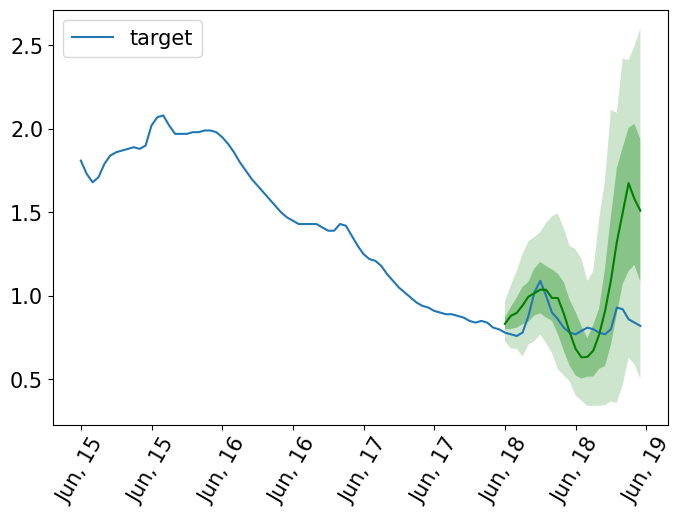

In [50]:
cl16 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'
cl32 = ckpt_dir + '/cl32_lr10e3/checkpoints/epoch=41-step=2100.ckpt'
cl64 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'

forecasts, tss = get_lag_llama_predictions(
    test,
    model_ckpt = cl32,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [56]:
_ckpt = torch.load('/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/cl16_lr10e3/checkpoints/epoch=46-step=2350.ckpt', 
                    map_location='cpu')
_ckpt['hyper_parameters']

In [59]:
_ckpt['hyper_parameters']['model_kwargs']['context_length']

16